# Import libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.debugger import set_trace
import json
from matplotlib import colors

# Load data

In [28]:
PATH = "../data/randnecklace/"
nodes = pd.read_csv(PATH + "node.csv", low_memory=False)
networks = pd.read_csv(PATH + "network.csv", low_memory=False)
info = pd.read_csv(PATH + "info.csv", low_memory=False)

# Preprocess data

In [29]:
# filter networks
network_data = networks
network_data = network_data[network_data["role"] == "experiment"]
network_data = network_data[network_data["failed"] == 'f']
network_data = network_data[network_data["trial_maker_id"] == 'graph_experiment']

experiment_net_id = list(network_data['id'].to_numpy())

# filter info
info_data = info
info_data = info_data[info["type"] == "graph_chain_trial"]
info_data = info_data[info_data["failed"] == "f"]
info_data = info_data[info_data["network_id"].isin(experiment_net_id)]
info_data = info_data[["id", "network_id", "origin_id", "answer", "definition"]]

# filter nodes
node_data = nodes
node_data = node_data[nodes["type"] == "graph_chain_node"]
node_data = node_data[node_data["failed"] == "f"]
node_data = node_data[node_data["network_id"].isin(experiment_net_id)]
node_data = node_data[["id", "network_id", "degree", "definition", "seed", "vertex_id", "dependent_vertex_ids"]]

Most common necklaces analysis

In [30]:
# Extracts the answer necklace
# answer (a) is given as a string formatted as "[i, [x, x, x, x, x, x, x, x, x]" where i is the choice of necklace in 'choice' round and the list is the necklace reproduced
# if the person tried to submit an invalid necklace first (containing '-1') there will be two lists
def extract_answer_necklace(a):
    a = a.strip('][').split(', ', 1)    # strip the outer brackets and split into choice/reproduce
    if '-1' in a[1]:                    # remove the invalid reproduced necklace if relevant
        a[1] = a[1].strip('[').split('], [')[1]
    a[1] = a[1].strip('][').split(', ') # remove the outer brackets of the necklace and split 
    a[1] = [int(x) for x in a[1]]       # turn circles into ints
    return a[1]

In [31]:
# Adds choice, parsed_definition, and reproduced_necklace columns
def extract_choice(a):
    a = a.strip('][').split(', ', 1)
    a = int(a[0])
    return a

def convert_json(d):
    return json.loads(d)

info_data["choice"] = info_data["answer"].apply(extract_choice)
info_data["parsed_definition"] = info_data["definition"].apply(convert_json)
info_data["reproduced_necklace"] = info_data["answer"].apply(extract_answer_necklace)

In [32]:
# Adds chosen_necklace column using above information
chosen_necklaces = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    curr_necklace = curr_row["parsed_definition"][curr_row["choice"]]["content"]
    chosen_necklaces.append(curr_necklace)
info_data["chosen_necklace"] = chosen_necklaces
# info_data["chosen_necklace"] = info_data.apply(lambda x: extract_chosen_necklace( info_data.parsed_definition, info_data.choice), axis=1)

In [33]:
def convert_to_pattern(necklace):
    color_to_code = {}
    pattern = []
    color_codes = ["a", "b", "c", "ERR"]
    color_index = 0

    if isinstance(necklace, str):
        necklace = necklace.strip('][').split(', ')

    for circle_color in necklace:
        if circle_color not in color_to_code:
            color_to_code[circle_color] = color_codes[color_index]
            color_index += 1
        pattern.append(color_to_code[circle_color])
    
    return pattern

In [34]:
info_data["chosen_necklace_pattern"] = info_data["chosen_necklace"].apply(convert_to_pattern)
info_data["reproduced_necklace_pattern"] = info_data["reproduced_necklace"].apply(convert_to_pattern)

In [35]:
degrees = []
for i in range(len(info_data)):
    curr_row = info_data.iloc[i]
    node_id = curr_row["origin_id"]
    node_row = node_data[node_data["id"] == node_id]
    degrees.append(node_row.iloc[0]["degree"])
info_data["degree"] = degrees
info_data = info_data.sort_values("degree")

In [36]:
# degree_freqs = {} # alternative for dict
degree_freqs = []
for i in range(1, 22):
    j = float(i)
    necklace_freqs = {}
    info_of_degree = info_data[info_data["degree"] == j]
    for necklace in info_of_degree["reproduced_necklace_pattern"]:
        necklace = str(necklace)
        if necklace in necklace_freqs:
            necklace_freqs[necklace] += 1
        else:
            necklace_freqs[necklace] = 1
    sorted_necklaces = sorted( ((v, k) for k, v in necklace_freqs.items()), reverse=True)
    degree_freqs.append(sorted_necklaces)
    # degree_freqs[j] = (sorted_necklaces) # alternative for dict

In [37]:
pd.DataFrame(degree_freqs).to_csv("rand-patterns-by-degree.csv")

In [38]:
# fraction of people agreeing
frac_degrees = []
for degree_list in degree_freqs:
    total_num = sum([l[0] for l in degree_list])
    top_three = []
    for i in range(3): # top three necklaces
        necklace = degree_list[i][1]
        frac = round(degree_list[i][0]/total_num, 2)
        top_three.append((frac, necklace))
    frac_degrees.append(top_three)

In [39]:
pd.DataFrame(frac_degrees).to_csv("rand-frac-agree-top-three.csv")

In [40]:
top_fracs = [top_three[0][0] for top_three in frac_degrees]
pd.DataFrame(top_fracs).to_csv("rand_top_frac.csv")
top_fracs = pd.read_csv("rand_top_frac.csv")["0"]

In [41]:
sum(top_fracs)/len(top_fracs)

0.5904761904761904

In [42]:
# fraction of people agreeing on secondary top necklace
second_fracs = [top_three[1][0] for top_three in frac_degrees]
pd.DataFrame(second_fracs).to_csv("rand_second_frac.csv")
second_fracs= pd.read_csv("rand_second_frac.csv")["0"]
# pd.DataFrame(second_fracs).plot(xlabel="degree", ylabel="fraction agreeing on second common necklace", title="fraction agreeing on second most common necklace, asocial condition", ylim=(0,1))

In [43]:
sum(second_fracs)/len(second_fracs)

0.10095238095238097

In [44]:
FIRST_PATH = "../../serial-reproduction-with-selection/analysis/"
social_top_fracs = pd.read_csv(FIRST_PATH + "social_top_frac.csv")["0"]
social_second_fracs = pd.read_csv(FIRST_PATH + "social_second_frac.csv")["0"]

asocial_top_fracs = pd.read_csv(FIRST_PATH + "asocial_top_frac.csv")["0"]
asocial_second_fracs = pd.read_csv(FIRST_PATH + "asocial_second_frac.csv")["0"]

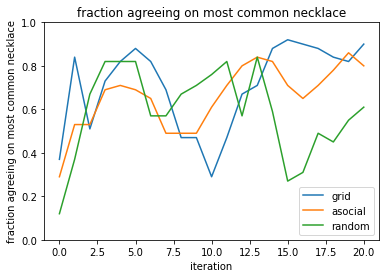

In [45]:
top_ax = social_top_fracs.plot(label="grid", xlabel="iteration", ylabel="fraction agreeing on most common necklace", title="fraction agreeing on most common necklace", ylim=(0,1))
asocial_top_fracs.plot(label="asocial", ax=top_ax)
top_fracs.plot(label="random", ax=top_ax)
top_ax.legend()

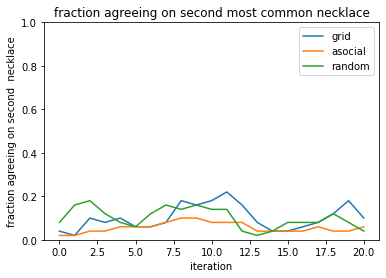

In [46]:
second_ax = social_second_fracs.plot(label="grid", xlabel="iteration", ylabel="fraction agreeing on second  necklace", title="fraction agreeing on second most common necklace", ylim=(0,1))
asocial_second_fracs.plot(ax=second_ax, label="asocial")
second_fracs.plot(ax=second_ax, label="random")
second_ax.legend()

<AxesSubplot:title={'center':'fraction agreeing on most common necklace, random condition'}, xlabel='degree', ylabel='fraction agreeing on top necklace'>

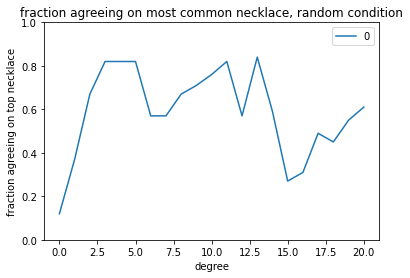

In [22]:
# fraction of people agreeing on top necklace
top_fracs = [top_three[0][0] for top_three in frac_degrees]
pd.DataFrame(top_fracs).plot(xlabel="degree", ylabel="fraction agreeing on top necklace", title="fraction agreeing on most common necklace, random condition", ylim=(0,1))

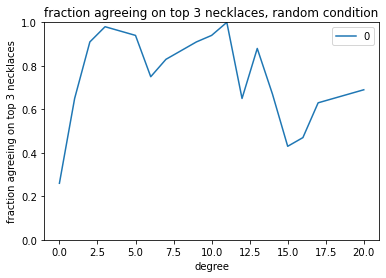

In [23]:
def top_sum(t):
    s = t[0][0] + t[1][0]
    if len(t) > 2 and t[2][0] != None:
        s += t[2][0]
    return s
top_fracs = [top_sum(t) for t in frac_degrees]
pd.DataFrame(top_fracs).plot(xlabel="degree", ylabel="fraction agreeing on top 3 necklaces", title="fraction agreeing on top 3 necklaces, random condition", ylim=(0,1))
pd.DataFrame(top_fracs).to_csv("top_three_frac_agree_random.csv")

In [24]:
max(top_fracs)

1.0

In [25]:
sum(top_fracs)/len(top_fracs)

0.7495238095238095